## Capstone- Cancer Histopathology: PCA

Dataset:
- A. Borkowski, "Lung and Colon Cancer Histopathological Images", Kaggle.com, 2020. [Online]. Available: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images. [Accessed: 30- Jul- 2022].

Sources:
- Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

Image Labels:
- Lung benign tissue: 3
- Lung adenocarcinoma: 2
- Lung squamous cell carcinoma: 4
- Colon adenocarcinoma: 0
- Colon benign tissue: 1

### Import Libraries

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
from pathlib import Path
import time
import math

# import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Data

In [2]:
import PIL
from PIL import Image
import glob
import cv2
import os, os.path
from numpy import asarray

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from IPython.display import display, HTML
import pymongo
from pymongo import MongoClient
import io
from bson.binary import Binary

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
%%time
dfShuffledData= pd.DataFrame(np.load('shufGenData96.npy', allow_pickle= True),
                             columns=['imageVector', 'label', 'classLabel', 'image', 'labelName'])
dfShuffledData.head()

CPU times: total: 4.55 s
Wall time: 28.2 s


,imageVector,label,classLabel,image,labelName
0,"[[[0.9960785, 0.98823535, 0.9921569], [0.98823...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca
1,"[[[0.98823535, 0.97647065, 0.9568628], [0.8470...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca
2,"[[[0.79215693, 0.6745098, 0.96470594], [0.7647...","[0.0, 0.0, 1.0, 0.0, 0.0]",2,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_aca
3,"[[[0.83921576, 0.5647059, 0.7686275], [0.85882...","[0.0, 0.0, 0.0, 1.0, 0.0]",3,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_n
4,"[[[0.40000004, 0.21176472, 0.7411765], [0.1647...","[0.0, 0.0, 0.0, 0.0, 1.0]",4,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_scc


In [5]:
arr1d= dfShuffledData['imageVector'][0].reshape(-1)

In [6]:
def flattenArray(imageArray):
    flatArr= imageArray.reshape(-1)
    return flatArr

In [7]:
dfShuffledData['flattenImage']= dfShuffledData['imageVector'].apply(lambda x: flattenArray(x))

In [8]:
dfShuffledData.head()

,imageVector,label,classLabel,image,labelName,flattenImage
0,"[[[0.9960785, 0.98823535, 0.9921569], [0.98823...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca,"[0.9960785, 0.98823535, 0.9921569, 0.98823535,..."
1,"[[[0.98823535, 0.97647065, 0.9568628], [0.8470...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca,"[0.98823535, 0.97647065, 0.9568628, 0.8470589,..."
2,"[[[0.79215693, 0.6745098, 0.96470594], [0.7647...","[0.0, 0.0, 1.0, 0.0, 0.0]",2,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_aca,"[0.79215693, 0.6745098, 0.96470594, 0.76470596..."
3,"[[[0.83921576, 0.5647059, 0.7686275], [0.85882...","[0.0, 0.0, 0.0, 1.0, 0.0]",3,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_n,"[0.83921576, 0.5647059, 0.7686275, 0.8588236, ..."
4,"[[[0.40000004, 0.21176472, 0.7411765], [0.1647...","[0.0, 0.0, 0.0, 0.0, 1.0]",4,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_scc,"[0.40000004, 0.21176472, 0.7411765, 0.16470589..."


In [9]:
flatImgArr= np.array(dfShuffledData['flattenImage'].tolist())

In [10]:
dfFlatImg= pd.DataFrame(flatImgArr)

In [11]:
dfFlatImg.head()

,0,1,2,3,4,5,6,7,8,9,...,27638,27639,27640,27641,27642,27643,27644,27645,27646,27647
0,0.996078,0.988235,0.992157,0.988235,1.000000,0.945098,0.980392,0.972549,0.925490,0.815686,...,0.780392,0.972549,0.992157,0.968628,0.992157,0.909804,0.968628,0.913726,0.749020,0.898039
1,0.988235,0.976471,0.956863,0.847059,0.733333,0.850980,0.929412,0.921569,0.870588,0.980392,...,0.968628,0.960784,0.901961,0.921569,1.000000,0.823529,0.964706,0.901961,0.658824,0.913726
2,0.792157,0.674510,0.964706,0.764706,0.592157,0.972549,0.776471,0.584314,0.996078,0.733333,...,0.933333,0.776471,0.623529,0.949020,0.650980,0.486275,0.909804,0.705882,0.607843,0.933333
3,0.839216,0.564706,0.768628,0.858824,0.556863,0.768628,0.882353,0.556863,0.776471,0.811765,...,0.749020,0.882353,0.580392,0.752941,0.898039,0.588235,0.764706,0.890196,0.580392,0.756863
4,0.400000,0.211765,0.741176,0.164706,0.000000,0.650980,0.109804,0.000000,0.603922,0.137255,...,0.756863,0.333333,0.192157,0.725490,0.352941,0.211765,0.705882,0.454902,0.317647,0.780392


In [12]:
dfFlatImg['target']= dfShuffledData['classLabel']

In [13]:
dfFlatImg.head()

,0,1,2,3,4,5,6,7,8,9,...,27639,27640,27641,27642,27643,27644,27645,27646,27647,target
0,0.996078,0.988235,0.992157,0.988235,1.000000,0.945098,0.980392,0.972549,0.925490,0.815686,...,0.972549,0.992157,0.968628,0.992157,0.909804,0.968628,0.913726,0.749020,0.898039,0
1,0.988235,0.976471,0.956863,0.847059,0.733333,0.850980,0.929412,0.921569,0.870588,0.980392,...,0.960784,0.901961,0.921569,1.000000,0.823529,0.964706,0.901961,0.658824,0.913726,0
2,0.792157,0.674510,0.964706,0.764706,0.592157,0.972549,0.776471,0.584314,0.996078,0.733333,...,0.776471,0.623529,0.949020,0.650980,0.486275,0.909804,0.705882,0.607843,0.933333,2
3,0.839216,0.564706,0.768628,0.858824,0.556863,0.768628,0.882353,0.556863,0.776471,0.811765,...,0.882353,0.580392,0.752941,0.898039,0.588235,0.764706,0.890196,0.580392,0.756863,3
4,0.400000,0.211765,0.741176,0.164706,0.000000,0.650980,0.109804,0.000000,0.603922,0.137255,...,0.333333,0.192157,0.725490,0.352941,0.211765,0.705882,0.454902,0.317647,0.780392,4


In [14]:
dfFlatImg.shape

(25000, 27649)

In [15]:
modelTag= ['LOGREG', 'SVC', 'RFC', 'MNB', 'GRADBST']
imageTag= []
for i in range(4, 10):
    if (i <= 9):
        img= f'image0{i}'
        imageTag.append(img)
    else:
        img= f'image{i}'
        imageTag.append(img)
imageTag

['image04', 'image05', 'image06', 'image07', 'image08', 'image09']

### Define Target and select Predictor features

In [16]:
predictor_columns= [c for c in dfFlatImg.columns if c != 'target']

In [17]:
X= pd.DataFrame(dfFlatImg, columns= predictor_columns)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,27638,27639,27640,27641,27642,27643,27644,27645,27646,27647
0,0.996078,0.988235,0.992157,0.988235,1.000000,0.945098,0.980392,0.972549,0.925490,0.815686,...,0.780392,0.972549,0.992157,0.968628,0.992157,0.909804,0.968628,0.913726,0.749020,0.898039
1,0.988235,0.976471,0.956863,0.847059,0.733333,0.850980,0.929412,0.921569,0.870588,0.980392,...,0.968628,0.960784,0.901961,0.921569,1.000000,0.823529,0.964706,0.901961,0.658824,0.913726
2,0.792157,0.674510,0.964706,0.764706,0.592157,0.972549,0.776471,0.584314,0.996078,0.733333,...,0.933333,0.776471,0.623529,0.949020,0.650980,0.486275,0.909804,0.705882,0.607843,0.933333
3,0.839216,0.564706,0.768628,0.858824,0.556863,0.768628,0.882353,0.556863,0.776471,0.811765,...,0.749020,0.882353,0.580392,0.752941,0.898039,0.588235,0.764706,0.890196,0.580392,0.756863
4,0.400000,0.211765,0.741176,0.164706,0.000000,0.650980,0.109804,0.000000,0.603922,0.137255,...,0.756863,0.333333,0.192157,0.725490,0.352941,0.211765,0.705882,0.454902,0.317647,0.780392


In [18]:
X.shape

(25000, 27648)

In [19]:
y= dfFlatImg['target']
y[0:10]

0    0
1    0
2    2
3    3
4    4
5    2
6    3
7    1
8    0
9    1
Name: target, dtype: object

**PCA**

In [20]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.20, random_state= 0)

In [21]:
X_train.columns

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            27638, 27639, 27640, 27641, 27642, 27643, 27644, 27645, 27646,
            27647],
           dtype='int64', length=27648)

In [22]:
len(X_train.columns)

27648

In [23]:
%%time
# Apply dimensionality reduction to Xs using transform
pca01= PCA(n_components= 100)
# Fit Xs
pcaModel01_Xtrain= pca01.fit_transform(X_train)
pcaModel01_Xtest= pca01.transform(X_test)
exp_var_pca01= pca01.explained_variance_ratio_
cum_sum_eigenvalues01= np.cumsum(exp_var_pca01)
pca01.singular_values_

CPU times: total: 2min 47s
Wall time: 45.7 s


array([2089.66    ,  963.506   ,  426.65683 ,  390.64413 ,  383.2409  ,
        341.18326 ,  331.78207 ,  305.26312 ,  299.8037  ,  294.11685 ,
        275.77377 ,  268.03574 ,  260.69232 ,  257.6228  ,  240.69064 ,
        238.6388  ,  237.15425 ,  235.2357  ,  227.5706  ,  225.71773 ,
        216.46298 ,  214.07027 ,  213.12143 ,  212.0703  ,  202.55733 ,
        201.39792 ,  199.0406  ,  196.44048 ,  194.01501 ,  192.70544 ,
        191.89018 ,  190.22221 ,  188.35558 ,  183.72023 ,  182.29759 ,
        180.46739 ,  179.61264 ,  176.84105 ,  176.41693 ,  172.21767 ,
        171.39438 ,  169.504   ,  167.66096 ,  167.41331 ,  166.84853 ,
        165.63533 ,  162.59737 ,  162.27748 ,  160.35919 ,  159.48004 ,
        159.00613 ,  157.76848 ,  156.25534 ,  155.59203 ,  154.27748 ,
        154.09276 ,  153.26999 ,  152.12498 ,  151.3426  ,  150.27394 ,
        149.71497 ,  148.55525 ,  147.53236 ,  146.52525 ,  145.50098 ,
        144.80338 ,  143.37553 ,  142.31213 ,  141.1478  ,  140.

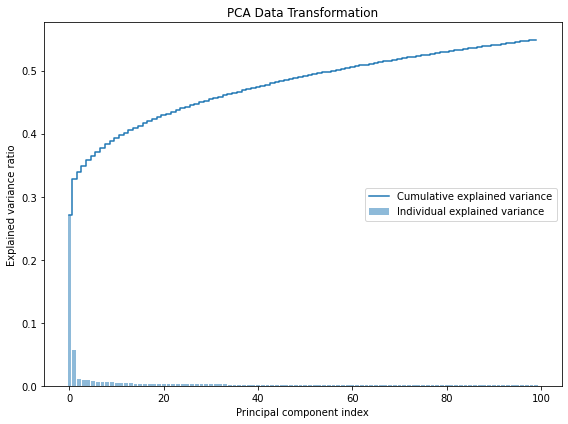

CPU times: total: 859 ms
Wall time: 917 ms


In [40]:
%%time
plt.figure(figsize=(8,6))
plt.bar(range(0,len(exp_var_pca01)), exp_var_pca01, alpha= 0.5, align= 'center',
        label= 'Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues01)), cum_sum_eigenvalues01, where= 'mid',
         label= 'Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('PCA Data Transformation')
plt.legend(loc= 'center right')
plt.tight_layout()
plt.savefig(f'{imageTag[0]}.png', facecolor='w', bbox_inches= "tight",
            pad_inches=0.3, transparent=True)
plt.show()

In [25]:
np.sum(exp_var_pca01)

0.54907215

In [26]:
pcaModel01_Xtrain

array([[-1.0386038e+01, -4.0176311e+00, -3.5737169e-01, ...,
        -4.7584471e-01, -3.5579827e-01,  5.8164585e-02],
       [-1.5743757e+01, -3.6644824e+00, -2.9681495e-01, ...,
         1.0289009e+00,  5.9800369e-01,  1.5514545e+00],
       [-4.4868207e+00,  1.2497447e+01, -3.9221510e-01, ...,
         6.1455983e-01,  2.4314670e-01,  1.0505362e+00],
       ...,
       [ 1.7612249e+01, -1.7924024e-01,  5.3639760e+00, ...,
         3.4579977e-02, -6.5006560e-01, -7.2086757e-01],
       [-1.1176865e+01,  1.0658999e+01, -3.6701446e+00, ...,
         3.2588688e-03,  4.9704084e-01, -8.9537460e-01],
       [-2.0223343e+01, -4.2083063e+00, -1.1765409e+00, ...,
        -1.0747058e+00,  3.8220215e-01, -1.9099941e+00]], dtype=float32)

In [27]:
pcaModel01_Xtest

array([[ -6.812259  ,  -2.800976  ,   0.7673089 , ...,  -0.09316329,
          0.02936506,  -0.20584369],
       [ -4.9533267 ,  12.512696  ,   1.106179  , ...,  -1.6931174 ,
          0.20081802,  -0.15675282],
       [ -8.010988  ,   8.186894  ,   1.8446515 , ...,  -0.5535216 ,
         -0.44648504,  -0.4879698 ],
       ...,
       [ 12.557629  ,  -2.7075667 ,   4.326359  , ...,   0.08249276,
         -0.35577983,  -0.0466103 ],
       [  7.067219  ,   0.9997433 ,   4.620945  , ...,   1.0482794 ,
         -1.835807  ,   0.90372974],
       [-18.590576  ,  -2.1829767 ,  -0.6482509 , ...,   0.3353271 ,
          0.5061962 ,   0.962367  ]], dtype=float32)

In [28]:
dfXtrain= pd.DataFrame(pcaModel01_Xtrain)
dfXtrain

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-10.386038,-4.017631,-0.357372,-1.250835,-2.144264,5.783551,-1.196920,1.465510,-0.508288,2.378150,...,-0.771041,-0.425177,-1.220840,-0.357108,-0.040824,2.252175,0.532710,-0.475845,-0.355798,0.058165
1,-15.743757,-3.664482,-0.296815,-1.924469,0.755236,-0.308575,-2.122058,0.711255,0.253594,1.459080,...,1.096240,-0.323564,0.219637,-0.851018,1.061086,0.340257,-0.239509,1.028901,0.598004,1.551455
2,-4.486821,12.497447,-0.392215,-1.011239,2.745016,2.081261,-0.774532,-1.553717,-7.416163,-0.768796,...,-0.588300,1.013568,0.181701,-1.876875,-0.058883,-0.261050,-0.726354,0.614560,0.243147,1.050536
3,-0.529217,-2.468542,-1.529118,-0.027930,1.781759,-2.139266,0.545642,-0.926475,2.544094,-0.229183,...,0.120040,0.066902,-0.158810,0.017205,1.468970,-1.793922,1.172353,0.646077,-0.466358,0.683118
4,-1.887423,12.217950,1.305322,0.662923,1.209968,-1.872509,-1.472102,2.988750,0.041355,2.071237,...,-0.561078,-0.932849,-0.785604,1.833534,0.645850,0.263929,-0.196678,-0.884208,-0.626668,-2.257778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-2.400931,-9.240097,-0.525111,-6.512236,-2.609425,-1.754646,-1.207316,-0.606029,1.939124,-2.427760,...,1.602193,1.164203,1.066416,0.135923,2.202394,1.285823,-0.240944,-0.790993,1.541535,1.770250
19996,-21.622551,-3.651836,0.546360,-7.427458,-3.700990,6.856483,-4.438756,5.851239,-5.804446,0.599285,...,-0.648024,-2.104229,-1.416624,-0.327796,-1.343260,0.243764,-0.418101,0.324632,-1.120537,0.270339
19997,17.612249,-0.179240,5.363976,-0.233951,-2.857253,-1.010815,1.185359,-2.206993,-3.978774,-1.155791,...,0.645975,0.457181,0.223789,0.031573,0.140991,0.400569,0.520781,0.034580,-0.650066,-0.720868
19998,-11.176865,10.658999,-3.670145,0.907725,-3.212272,-0.342592,0.611351,-0.334796,1.526569,-0.445187,...,0.252911,-0.440737,-0.463834,-1.433399,-0.380679,1.032027,0.127512,0.003259,0.497041,-0.895375


In [29]:
dfXtest= pd.DataFrame(pcaModel01_Xtest)
dfXtest

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-6.812259,-2.800976,0.767309,-2.775392,-3.719448,0.844926,-3.353663,-0.043430,1.740235,-2.364534,...,0.224123,-0.218247,0.026769,0.077800,0.320466,1.661507,-0.610502,-0.093163,0.029365,-0.205844
1,-4.953327,12.512696,1.106179,-3.496313,-0.751542,1.040564,-1.007241,1.505262,-1.053580,-0.341322,...,0.409257,-0.813439,-0.898447,0.913909,1.786346,2.083232,0.247697,-1.693117,0.200818,-0.156753
2,-8.010988,8.186894,1.844651,1.445616,-5.075667,-3.255281,-3.667675,1.308030,0.196971,-6.070621,...,0.585778,-0.140508,-0.048202,-0.834168,-0.090006,0.941000,1.151056,-0.553522,-0.446485,-0.487970
3,-10.227389,-2.655595,-0.742239,-2.838906,0.857027,0.575222,-0.962005,0.041057,-1.524368,-0.699158,...,-0.189281,-0.192767,-0.178202,0.387299,-1.730869,0.369956,-0.254867,0.586279,1.489795,-0.682087
4,25.914148,-4.263391,1.312389,0.388454,-0.579276,-0.541660,1.900562,0.413293,0.665295,1.868161,...,-0.098617,0.641602,1.209360,-0.344521,1.331513,0.110570,-1.152149,0.195930,-1.043518,1.645348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,16.404327,-0.168074,-5.398320,-2.718031,2.460010,-1.234453,-0.688607,-1.279402,0.810343,-0.473418,...,-0.375124,-0.218407,-0.522434,0.207717,0.124622,-0.588774,-0.154050,-0.801123,0.424762,-0.126466
4996,-4.337116,7.755393,1.732252,-0.278802,0.533503,-2.214538,1.552801,5.569502,-1.531425,5.359146,...,-0.365781,0.097631,-1.197622,-0.482358,2.212669,-0.523287,-0.254100,-0.389182,2.881077,-0.998906
4997,12.557629,-2.707567,4.326359,1.958212,0.753780,1.886256,5.173120,-2.418170,-3.549871,-1.452338,...,-0.708531,-1.749011,-0.913743,-0.662536,-1.566788,0.072999,1.210039,0.082493,-0.355780,-0.046610
4998,7.067219,0.999743,4.620945,-0.380740,2.303043,-0.243800,2.881824,-1.299755,-0.505629,0.415786,...,-1.055156,0.422536,-0.489410,-1.145594,0.811671,-0.280356,0.648114,1.048279,-1.835807,0.903730


In [30]:
y_train.values

array([0, 0, 3, ..., 2, 3, 0], dtype=object)

In [31]:
y_test.values

array([0, 3, 3, ..., 4, 2, 0], dtype=object)

In [32]:
dfYtrain= pd.DataFrame(y_train.values, columns= ['target'])
dfYtrain

,target
0,0
1,0
2,3
3,0
4,3
...,...
19995,2
19996,1
19997,2
19998,3


In [33]:
dfYtest= pd.DataFrame(y_test.values, columns= ['target'])
dfYtest

,target
0,0
1,3
2,3
3,1
4,4
...,...
4995,4
4996,3
4997,4
4998,2


In [34]:
pcaXtrain= pd.concat([dfXtrain, dfYtrain], axis=1)
pcaXtrain

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,target
0,-10.386038,-4.017631,-0.357372,-1.250835,-2.144264,5.783551,-1.196920,1.465510,-0.508288,2.378150,...,-0.425177,-1.220840,-0.357108,-0.040824,2.252175,0.532710,-0.475845,-0.355798,0.058165,0
1,-15.743757,-3.664482,-0.296815,-1.924469,0.755236,-0.308575,-2.122058,0.711255,0.253594,1.459080,...,-0.323564,0.219637,-0.851018,1.061086,0.340257,-0.239509,1.028901,0.598004,1.551455,0
2,-4.486821,12.497447,-0.392215,-1.011239,2.745016,2.081261,-0.774532,-1.553717,-7.416163,-0.768796,...,1.013568,0.181701,-1.876875,-0.058883,-0.261050,-0.726354,0.614560,0.243147,1.050536,3
3,-0.529217,-2.468542,-1.529118,-0.027930,1.781759,-2.139266,0.545642,-0.926475,2.544094,-0.229183,...,0.066902,-0.158810,0.017205,1.468970,-1.793922,1.172353,0.646077,-0.466358,0.683118,0
4,-1.887423,12.217950,1.305322,0.662923,1.209968,-1.872509,-1.472102,2.988750,0.041355,2.071237,...,-0.932849,-0.785604,1.833534,0.645850,0.263929,-0.196678,-0.884208,-0.626668,-2.257778,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-2.400931,-9.240097,-0.525111,-6.512236,-2.609425,-1.754646,-1.207316,-0.606029,1.939124,-2.427760,...,1.164203,1.066416,0.135923,2.202394,1.285823,-0.240944,-0.790993,1.541535,1.770250,2
19996,-21.622551,-3.651836,0.546360,-7.427458,-3.700990,6.856483,-4.438756,5.851239,-5.804446,0.599285,...,-2.104229,-1.416624,-0.327796,-1.343260,0.243764,-0.418101,0.324632,-1.120537,0.270339,1
19997,17.612249,-0.179240,5.363976,-0.233951,-2.857253,-1.010815,1.185359,-2.206993,-3.978774,-1.155791,...,0.457181,0.223789,0.031573,0.140991,0.400569,0.520781,0.034580,-0.650066,-0.720868,2
19998,-11.176865,10.658999,-3.670145,0.907725,-3.212272,-0.342592,0.611351,-0.334796,1.526569,-0.445187,...,-0.440737,-0.463834,-1.433399,-0.380679,1.032027,0.127512,0.003259,0.497041,-0.895375,3


In [35]:
pcaXtrain.shape

(20000, 101)

In [36]:
pcaXtest= pd.concat([dfXtest, dfYtest], axis=1)
pcaXtest

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,target
0,-6.812259,-2.800976,0.767309,-2.775392,-3.719448,0.844926,-3.353663,-0.043430,1.740235,-2.364534,...,-0.218247,0.026769,0.077800,0.320466,1.661507,-0.610502,-0.093163,0.029365,-0.205844,0
1,-4.953327,12.512696,1.106179,-3.496313,-0.751542,1.040564,-1.007241,1.505262,-1.053580,-0.341322,...,-0.813439,-0.898447,0.913909,1.786346,2.083232,0.247697,-1.693117,0.200818,-0.156753,3
2,-8.010988,8.186894,1.844651,1.445616,-5.075667,-3.255281,-3.667675,1.308030,0.196971,-6.070621,...,-0.140508,-0.048202,-0.834168,-0.090006,0.941000,1.151056,-0.553522,-0.446485,-0.487970,3
3,-10.227389,-2.655595,-0.742239,-2.838906,0.857027,0.575222,-0.962005,0.041057,-1.524368,-0.699158,...,-0.192767,-0.178202,0.387299,-1.730869,0.369956,-0.254867,0.586279,1.489795,-0.682087,1
4,25.914148,-4.263391,1.312389,0.388454,-0.579276,-0.541660,1.900562,0.413293,0.665295,1.868161,...,0.641602,1.209360,-0.344521,1.331513,0.110570,-1.152149,0.195930,-1.043518,1.645348,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,16.404327,-0.168074,-5.398320,-2.718031,2.460010,-1.234453,-0.688607,-1.279402,0.810343,-0.473418,...,-0.218407,-0.522434,0.207717,0.124622,-0.588774,-0.154050,-0.801123,0.424762,-0.126466,4
4996,-4.337116,7.755393,1.732252,-0.278802,0.533503,-2.214538,1.552801,5.569502,-1.531425,5.359146,...,0.097631,-1.197622,-0.482358,2.212669,-0.523287,-0.254100,-0.389182,2.881077,-0.998906,3
4997,12.557629,-2.707567,4.326359,1.958212,0.753780,1.886256,5.173120,-2.418170,-3.549871,-1.452338,...,-1.749011,-0.913743,-0.662536,-1.566788,0.072999,1.210039,0.082493,-0.355780,-0.046610,4
4998,7.067219,0.999743,4.620945,-0.380740,2.303043,-0.243800,2.881824,-1.299755,-0.505629,0.415786,...,0.422536,-0.489410,-1.145594,0.811671,-0.280356,0.648114,1.048279,-1.835807,0.903730,2


In [37]:
pcaXtest.shape

(5000, 101)

In [38]:
new_PCA= pd.concat([pcaXtrain, pcaXtest], axis=0)
new_PCA

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,target
0,-10.386038,-4.017631,-0.357372,-1.250835,-2.144264,5.783551,-1.196920,1.465510,-0.508288,2.378150,...,-0.425177,-1.220840,-0.357108,-0.040824,2.252175,0.532710,-0.475845,-0.355798,0.058165,0
1,-15.743757,-3.664482,-0.296815,-1.924469,0.755236,-0.308575,-2.122058,0.711255,0.253594,1.459080,...,-0.323564,0.219637,-0.851018,1.061086,0.340257,-0.239509,1.028901,0.598004,1.551455,0
2,-4.486821,12.497447,-0.392215,-1.011239,2.745016,2.081261,-0.774532,-1.553717,-7.416163,-0.768796,...,1.013568,0.181701,-1.876875,-0.058883,-0.261050,-0.726354,0.614560,0.243147,1.050536,3
3,-0.529217,-2.468542,-1.529118,-0.027930,1.781759,-2.139266,0.545642,-0.926475,2.544094,-0.229183,...,0.066902,-0.158810,0.017205,1.468970,-1.793922,1.172353,0.646077,-0.466358,0.683118,0
4,-1.887423,12.217950,1.305322,0.662923,1.209968,-1.872509,-1.472102,2.988750,0.041355,2.071237,...,-0.932849,-0.785604,1.833534,0.645850,0.263929,-0.196678,-0.884208,-0.626668,-2.257778,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,16.404327,-0.168074,-5.398320,-2.718031,2.460010,-1.234453,-0.688607,-1.279402,0.810343,-0.473418,...,-0.218407,-0.522434,0.207717,0.124622,-0.588774,-0.154050,-0.801123,0.424762,-0.126466,4
4996,-4.337116,7.755393,1.732252,-0.278802,0.533503,-2.214538,1.552801,5.569502,-1.531425,5.359146,...,0.097631,-1.197622,-0.482358,2.212669,-0.523287,-0.254100,-0.389182,2.881077,-0.998906,3
4997,12.557629,-2.707567,4.326359,1.958212,0.753780,1.886256,5.173120,-2.418170,-3.549871,-1.452338,...,-1.749011,-0.913743,-0.662536,-1.566788,0.072999,1.210039,0.082493,-0.355780,-0.046610,4
4998,7.067219,0.999743,4.620945,-0.380740,2.303043,-0.243800,2.881824,-1.299755,-0.505629,0.415786,...,0.422536,-0.489410,-1.145594,0.811671,-0.280356,0.648114,1.048279,-1.835807,0.903730,2


In [39]:
%%time
filepath = Path('pcaDataset04.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
new_PCA.to_csv(filepath)

CPU times: total: 3.58 s
Wall time: 3.79 s
